# HDI Dataset — Statistical Interpretation & Exploratory Data Analysis (Assignment I)

**Course:** 5CS037 Concepts and Technologies of AI (Herald College, Kathmandu)  
**Dataset:** `Human_Development_Index_Dataset.csv` (1990–2022)  

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CSV_PATH = r"/content/drive/MyDrive/Human_Development_Index_Dataset.csv"

# the CSV contains some non-UTF8 characters. latin1 is a safe read for this dataset.
df_raw = pd.read_csv(CSV_PATH, encoding="latin1")
print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (6798, 30)


,Unnamed: 0,iso3,country,year,hdi,life_expectancy,pop_millions,hdi_f,hdi_m,life_expec_f,...,gender_development,gender_inequality,secondary_education_f_%,secondary_education_m_%,seats_in_parliament_f_%,seats_in_parliament_m_%,labour_participation_f_%,labour_participation_m_%,co2_emission_tons,mat_footprint_percap_tons
0,1,AFG,Afghanistan,1990,0.284,45.967,10.694796,NaN,NaN,48.397,...,NaN,NaN,1.107733,7.899011,NaN,NaN,NaN,NaN,0.189279,2.1809
1,2,AFG,Afghanistan,1991,0.292,46.663,10.745167,NaN,NaN,49.144,...,NaN,NaN,1.221396,8.137953,NaN,NaN,NaN,NaN,0.178155,2.5264
2,3,AFG,Afghanistan,1992,0.299,47.596,12.057433,NaN,NaN,50.320,...,NaN,NaN,1.335059,8.376896,NaN,NaN,NaN,NaN,0.122920,2.6421
3,4,AFG,Afghanistan,1993,0.307,51.466,14.003760,NaN,NaN,52.739,...,NaN,NaN,1.448722,8.615838,NaN,NaN,NaN,NaN,0.106179,2.3022
4,5,AFG,Afghanistan,1994,0.300,51.495,15.455554,NaN,NaN,53.544,...,NaN,NaN,1.562385,8.854780,NaN,NaN,NaN,NaN,0.094063,1.8948


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Helper: Cleaning utilities

The assignment asks us to check for:
- numeric columns stored as text,
- special characters like “–” representing missing values,
- duplicates,
- inconsistent country names.

Below is a small cleaning pipeline:
- standardize missing markers to `NaN`
- strip whitespace from country names
- convert numeric columns with `pd.to_numeric(..., errors="coerce")`
- drop duplicate rows
- drop rows missing essential fields (`country`, `year`, `hdi`) for analyses that require them


In [4]:
def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Standardize common missing markers
    missing_markers = ["–", "—", "-", "NA", "N/A", "na", "n/a", "null", "None", ""]
    df = df.replace(missing_markers, np.nan)

    # Country cleanup
    if "country" in df.columns:
        df["country"] = df["country"].astype(str).str.strip()

    # Convert year to int where possible
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

    # Convert all other likely-numeric columns to numeric (keep country/iso3 as text)
    non_numeric = {"country", "iso3"}
    for col in df.columns:
        if col not in non_numeric:
            # Try numeric conversion; non-numeric values become NaN
            df[col] = pd.to_numeric(df[col], errors="ignore")
            # If still object, coerce to numeric (safe for mixed columns)
            if df[col].dtype == "object":
                df[col] = pd.to_numeric(df[col], errors="coerce")

    # Drop exact duplicate rows
    before = len(df)
    df = df.drop_duplicates()
    after = len(df)
    if before != after:
        print(f"Dropped duplicates: {before-after}")

    return df

df = basic_clean(df_raw)

print("Cleaned shape:", df.shape)
df.dtypes.head(10)


Cleaned shape: (6798, 30)


/tmp/ipython-input-989885372.py:21: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


,0
Unnamed: 0,int64
iso3,object
country,object
year,Int64
hdi,float64
life_expectancy,float64
pop_millions,float64
hdi_f,float64
hdi_m,float64
life_expec_f,float64


# Problem 1A — Single Year HDI Exploration (Latest Year: 2022)

## Task 1 — Extract Latest Year (2022)

- Identify unique years
- Filter dataset to year **2022**
- Save as `hdi_2022_df`


In [5]:
# Unique years in the dataset
unique_years = sorted(df["year"].dropna().unique().tolist())
print("Unique years (min..max):", unique_years[0], "..", unique_years[-1])
print("Number of unique years:", len(unique_years))

# Filter for 2022
hdi_2022_df = df[df["year"] == 2022].copy()
print("2022 shape:", hdi_2022_df.shape)

hdi_2022_df.head()


Unique years (min..max): 1990 .. 2022
Number of unique years: 33
2022 shape: (206, 30)


,Unnamed: 0,iso3,country,year,hdi,life_expectancy,pop_millions,hdi_f,hdi_m,life_expec_f,...,gender_development,gender_inequality,secondary_education_f_%,secondary_education_m_%,seats_in_parliament_f_%,seats_in_parliament_m_%,labour_participation_f_%,labour_participation_m_%,co2_emission_tons,mat_footprint_percap_tons
32,33,AFG,Afghanistan,2022,0.462,62.879,41.128771,0.332443,0.534145,66.213,...,0.622,0.665,7.042050,24.077040,27.215190,72.784810,23.33,77.09,0.306318,1.1809
65,66,ALB,Albania,2022,0.789,76.833,2.842321,0.780277,0.798432,79.472,...,0.977,0.116,82.249185,86.476634,35.714286,64.285714,56.08,69.91,1.717758,11.7367
98,99,DZA,Algeria,2022,0.745,77.129,44.903225,0.681844,0.773800,78.457,...,0.881,0.460,42.910456,46.815170,7.005254,92.994746,17.57,65.53,4.079540,8.7199
131,132,AND,Andorra,2022,0.884,83.552,0.079824,NaN,NaN,85.838,...,NaN,NaN,81.718277,84.599998,46.428571,53.571429,NaN,NaN,4.593593,NaN
164,165,AGO,Angola,2022,0.591,61.929,35.588987,0.560890,0.619680,64.541,...,0.905,0.520,21.339865,37.411946,33.636364,66.363636,74.73,78.16,0.507359,3.6568


## Task 2 — Data Exploration (2022)

- Display first 10 rows
- Count rows/columns
- Column names and data types


In [6]:
display(hdi_2022_df.head(10))

print("Rows:", hdi_2022_df.shape[0], "Columns:", hdi_2022_df.shape[1])

col_info = pd.DataFrame({
    "column": hdi_2022_df.columns,
    "dtype": [str(t) for t in hdi_2022_df.dtypes]
})
col_info


,Unnamed: 0,iso3,country,year,hdi,life_expectancy,pop_millions,hdi_f,hdi_m,life_expec_f,...,gender_development,gender_inequality,secondary_education_f_%,secondary_education_m_%,seats_in_parliament_f_%,seats_in_parliament_m_%,labour_participation_f_%,labour_participation_m_%,co2_emission_tons,mat_footprint_percap_tons
32,33,AFG,Afghanistan,2022,0.462,62.879,41.128771,0.332443,0.534145,66.213,...,0.622,0.665,7.042050,24.077040,27.215190,72.784810,23.33,77.09,0.306318,1.1809
65,66,ALB,Albania,2022,0.789,76.833,2.842321,0.780277,0.798432,79.472,...,0.977,0.116,82.249185,86.476634,35.714286,64.285714,56.08,69.91,1.717758,11.7367
98,99,DZA,Algeria,2022,0.745,77.129,44.903225,0.681844,0.773800,78.457,...,0.881,0.460,42.910456,46.815170,7.005254,92.994746,17.57,65.53,4.079540,8.7199
131,132,AND,Andorra,2022,0.884,83.552,0.079824,NaN,NaN,85.838,...,NaN,NaN,81.718277,84.599998,46.428571,53.571429,NaN,NaN,4.593593,NaN
164,165,AGO,Angola,2022,0.591,61.929,35.588987,0.560890,0.619680,64.541,...,0.905,0.520,21.339865,37.411946,33.636364,66.363636,74.73,78.16,0.507359,3.6568
197,198,ATG,Antigua and Barbuda,2022,0.826,79.236,0.093763,NaN,NaN,81.645,...,NaN,NaN,NaN,NaN,31.428571,68.571429,NaN,NaN,6.401056,NaN
230,231,ARG,Argentina,2022,0.849,76.064,45.510318,0.841405,0.845473,79.277,...,0.995,0.292,73.591541,71.648085,44.376900,55.623100,52.08,71.74,4.190779,14.4512
263,264,ARM,Armenia,2022,0.786,73.372,2.780469,0.795110,0.774942,78.447,...,1.026,0.198,96.001381,97.050957,35.514019,64.485981,62.80,71.84,2.531088,7.3553
296,297,AUS,Australia,2022,0.946,83.579,26.177414,0.934602,0.955941,85.453,...,0.978,0.063,94.580063,94.430069,44.493392,55.506608,62.31,71.13,14.914763,26.9245
329,330,AUT,Austria,2022,0.926,82.412,8.939617,0.911592,0.937756,84.600,...,0.972,0.048,100.000000,100.000000,40.983607,59.016393,56.55,66.69,7.399461,27.9621


Rows: 206 Columns: 30


,column,dtype
0,Unnamed: 0,int64
1,iso3,object
2,country,object
3,year,Int64
4,hdi,float64
5,life_expectancy,float64
6,pop_millions,float64
7,hdi_f,float64
8,hdi_m,float64
9,life_expec_f,float64


## Task 3 — Missing Values & Data Cleaning (2022)

We will:
- report missing counts
- ensure numeric columns are numeric
- remove duplicates
- handle missing values

**Decision (justification):**
- For essential analysis columns (`country`, `year`, `hdi`) we **drop** rows with missing values because we cannot compute rankings/statistics without them.
- For non-essential numeric columns, we **impute** missing values with the **median** of that column (within 2022) so that downstream filtering/sorting/plots are possible without losing too many countries.


In [7]:
# Missing values per column
missing_2022 = hdi_2022_df.isna().sum().sort_values(ascending=False)
missing_2022

# Remove duplicates (if any)
before = len(hdi_2022_df)
hdi_2022_df = hdi_2022_df.drop_duplicates()
print("Dropped duplicates in 2022:", before - len(hdi_2022_df))

# Drop rows missing essential columns
essential = ["country", "year", "hdi"]
before = len(hdi_2022_df)
hdi_2022_df = hdi_2022_df.dropna(subset=essential)
print("Dropped rows missing essential fields:", before - len(hdi_2022_df))

# Impute remaining numeric columns with median (within 2022)
numeric_cols = hdi_2022_df.select_dtypes(include=[np.number]).columns.tolist()
for c in numeric_cols:
    if hdi_2022_df[c].isna().any():
        hdi_2022_df[c] = hdi_2022_df[c].fillna(hdi_2022_df[c].median())

hdi_2022_df.isna().sum().sort_values(ascending=False).head(10)


Dropped duplicates in 2022: 0
Dropped rows missing essential fields: 2


,0
Unnamed: 0,0
iso3,0
country,0
year,0
hdi,0
life_expectancy,0
pop_millions,0
hdi_f,0
hdi_m,0
life_expec_f,0


## Task 4 — Basic Statistics (HDI 2022)

- mean, median, std of `hdi`
- country with highest HDI
- country with lowest HDI


In [8]:
hdi_mean = hdi_2022_df["hdi"].mean()
hdi_median = hdi_2022_df["hdi"].median()
hdi_std = hdi_2022_df["hdi"].std()

print(f"HDI 2022 mean:   {hdi_mean:.4f}")
print(f"HDI 2022 median: {hdi_median:.4f}")
print(f"HDI 2022 std:    {hdi_std:.4f}")

highest = hdi_2022_df.loc[hdi_2022_df["hdi"].idxmax(), ["country", "hdi"]]
lowest  = hdi_2022_df.loc[hdi_2022_df["hdi"].idxmin(), ["country", "hdi"]]

print("\nHighest HDI (2022):")
display(highest.to_frame().T)

print("\nLowest HDI (2022):")
display(lowest.to_frame().T)


HDI 2022 mean:   0.7229
HDI 2022 median: 0.7395
HDI 2022 std:    0.1530

Highest HDI (2022):


,country,hdi
5609,Switzerland,0.967



Lowest HDI (2022):


,country,hdi
5345,Somalia,0.38


## Task 5 — Filtering & Sorting

- Filter countries with `hdi > 0.800`
- Sort by `gross_inc_percap` descending
- Show top 10


In [9]:
filtered = hdi_2022_df[hdi_2022_df["hdi"] > 0.800].copy()

# Sort by GNI per Capita (gross_inc_percap) descending
filtered_sorted = filtered.sort_values(by="gross_inc_percap", ascending=False)

display(filtered_sorted[["country", "hdi", "gross_inc_percap"]].head(10))
print("Count of countries with HDI > 0.800:", len(filtered_sorted))


,country,hdi,gross_inc_percap
3332,Liechtenstein,0.942,146673.24150
4718,Qatar,0.875,95944.37754
5213,Singapore,0.949,88761.14559
2705,Ireland,0.950,87467.51391
3398,Luxembourg,0.927,78554.23640
6104,United Arab Emirates,0.937,74103.71494
5609,Switzerland,0.967,69432.78669
4322,Norway,0.966,69189.76165
6170,United States,0.927,65564.93798
2474,"Hong Kong, China (SAR)",0.956,62485.50516


Count of countries with HDI > 0.800: 71


## Task 6 — Add `HDI Category` Column (UNDP thresholds)

- Low: < 0.550  
- Medium: 0.550–0.699  
- High: 0.700–0.799  
- Very High: ≥ 0.800  

Export: **`HDI category added.csv`**


In [10]:
def hdi_category(hdi: float) -> str:
    if pd.isna(hdi):
        return np.nan
    if hdi < 0.550:
        return "Low"
    elif 0.550 <= hdi <= 0.699:
        return "Medium"
    elif 0.700 <= hdi <= 0.799:
        return "High"
    else:
        return "Very High"

hdi_2022_df["HDI Category"] = hdi_2022_df["hdi"].apply(hdi_category)

# Verify categories
hdi_2022_df["HDI Category"].value_counts(dropna=False)


,count
HDI Category,
Very High,71
High,54
Medium,44
Low,35


In [11]:
# Save required CSV
out_1a = "/content/drive/MyDrive/HDI category added.csv"
hdi_2022_df.to_csv(out_1a, index=False)
print("Saved:", out_1a)

hdi_2022_df.head()


Saved: /content/drive/MyDrive/HDI category added.csv


,Unnamed: 0,iso3,country,year,hdi,life_expectancy,pop_millions,hdi_f,hdi_m,life_expec_f,...,gender_inequality,secondary_education_f_%,secondary_education_m_%,seats_in_parliament_f_%,seats_in_parliament_m_%,labour_participation_f_%,labour_participation_m_%,co2_emission_tons,mat_footprint_percap_tons,HDI Category
32,33,AFG,Afghanistan,2022,0.462,62.879,41.128771,0.332443,0.534145,66.213,...,0.665,7.042050,24.077040,27.215190,72.784810,23.33,77.09,0.306318,1.1809,Low
65,66,ALB,Albania,2022,0.789,76.833,2.842321,0.780277,0.798432,79.472,...,0.116,82.249185,86.476634,35.714286,64.285714,56.08,69.91,1.717758,11.7367,High
98,99,DZA,Algeria,2022,0.745,77.129,44.903225,0.681844,0.773800,78.457,...,0.460,42.910456,46.815170,7.005254,92.994746,17.57,65.53,4.079540,8.7199,High
131,132,AND,Andorra,2022,0.884,83.552,0.079824,0.728905,0.751399,85.838,...,0.360,81.718277,84.599998,46.428571,53.571429,52.16,70.58,4.593593,9.9662,Very High
164,165,AGO,Angola,2022,0.591,61.929,35.588987,0.560890,0.619680,64.541,...,0.520,21.339865,37.411946,33.636364,66.363636,74.73,78.16,0.507359,3.6568,Medium


# Problem 1B — HDI Visualization and Trend Analysis (2020–2022)

## Task 1 — Filter for 2020, 2021, 2022 and Save

Export: **`HDI problem1B.csv`**


In [12]:
years_1b = [2020, 2021, 2022]
hdi_1b = df[df["year"].isin(years_1b)].copy()
print("Problem 1B raw subset shape:", hdi_1b.shape)

# Basic cleaning for essentials
hdi_1b = hdi_1b.dropna(subset=["country", "year", "hdi"]).drop_duplicates()
print("After dropping missing essentials & duplicates:", hdi_1b.shape)

out_1b = "/content/drive/MyDrive/HDI problem1B.csv"
hdi_1b.to_csv(out_1b, index=False)
print("Saved:", out_1b)

hdi_1b.head()


Problem 1B raw subset shape: (618, 30)
After dropping missing essentials & duplicates: (610, 30)
Saved: /content/drive/MyDrive/HDI problem1B.csv


,Unnamed: 0,iso3,country,year,hdi,life_expectancy,pop_millions,hdi_f,hdi_m,life_expec_f,...,gender_development,gender_inequality,secondary_education_f_%,secondary_education_m_%,seats_in_parliament_f_%,seats_in_parliament_m_%,labour_participation_f_%,labour_participation_m_%,co2_emission_tons,mat_footprint_percap_tons
30,31,AFG,Afghanistan,2020,0.488,62.575,38.972231,0.381373,0.548741,65.432,...,0.695,0.674,6.092345,15.945160,27.215190,72.784810,16.50,66.84,0.305040,1.5554
31,32,AFG,Afghanistan,2021,0.473,61.982,40.099462,0.379129,0.528559,65.279,...,0.717,0.653,6.395730,14.865710,27.215190,72.784810,23.33,77.09,0.306318,1.2351
32,33,AFG,Afghanistan,2022,0.462,62.879,41.128771,0.332443,0.534145,66.213,...,0.622,0.665,7.042050,24.077040,27.215190,72.784810,23.33,77.09,0.306318,1.1809
63,64,ALB,Albania,2020,0.784,76.989,2.866849,0.775404,0.793220,79.676,...,0.978,0.129,82.249185,86.476634,29.508197,70.491803,54.45,68.91,1.750668,10.4704
64,65,ALB,Albania,2021,0.785,76.463,2.854710,0.777866,0.792942,79.173,...,0.981,0.117,82.249185,86.476634,35.714286,64.285714,56.08,69.91,1.717758,11.5865


## Task 2 — Data Cleaning Checks (Essentials)

We explicitly check missing values for:
- `hdi`
- `country`
- `year`


In [13]:
essential_cols = ["hdi", "country", "year"]
hdi_1b[essential_cols].isna().sum()


,0
hdi,0
country,0
year,0


## Task 3A — Line Chart: HDI Trend (Country-level) for 5 countries

We'll select 5 countries (editable list).

In [14]:
selected_countries = ["Nepal", "India", "Bangladesh", "Sri Lanka", "Pakistan"]

trend = (hdi_1b[hdi_1b["country"].isin(selected_countries)]
         .sort_values(["country", "year"])
         [["country", "year", "hdi"]])

trend_pivot = trend.pivot(index="year", columns="country", values="hdi")
trend_pivot


country,Bangladesh,India,Nepal,Pakistan,Sri Lanka
year,,,,,
2020,0.657,0.638,0.593,0.536,0.777
2021,0.662,0.633,0.591,0.537,0.783
2022,0.670,0.644,0.601,0.540,0.780


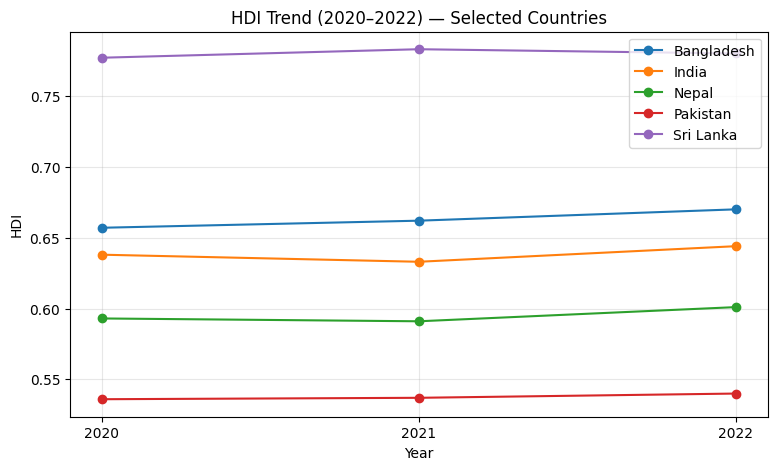

Caption: Each line shows HDI changes from 2020 to 2022 for a selected country.


In [15]:
plt.figure(figsize=(9, 5))
for c in trend_pivot.columns:
    plt.plot(trend_pivot.index, trend_pivot[c], marker="o", label=c)

plt.title("HDI Trend (2020–2022) — Selected Countries")
plt.xlabel("Year")
plt.ylabel("HDI")
plt.xticks([2020, 2021, 2022])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Caption: Each line shows HDI changes from 2020 to 2022 for a selected country.")


## Task 3B — Visualizations

### 1) Bar Chart: Average HDI by Region (2020–2022)


The  HDI dataset does not contain an explicit region column.
Therefore, I constructed a region variable  manually using a country-to-region mapping for South Asia and the Middle East.
Countries outside these regions were excluded from this specific analysis.

In [16]:
region_map = {
    # South Asia
    "Afghanistan": "South Asia",
    "Bangladesh": "South Asia",
    "Bhutan": "South Asia",
    "India": "South Asia",
    "Maldives": "South Asia",
    "Nepal": "South Asia",
    "Pakistan": "South Asia",
    "Sri Lanka": "South Asia",

    # Middle East
    "Bahrain": "Middle East",
    "Iran": "Middle East",
    "Iraq": "Middle East",
    "Israel": "Middle East",
    "Jordan": "Middle East",
    "Kuwait": "Middle East",
    "Lebanon": "Middle East",
    "Oman": "Middle East",
    "Palestine": "Middle East",
    "Qatar": "Middle East",
    "Saudi Arabia": "Middle East",
    "Syria": "Middle East",
    "United Arab Emirates": "Middle East",
    "Yemen": "Middle East"
}


In [17]:
hdi_1b["region"] = hdi_1b["country"].map(region_map)
hdi_1b_region = hdi_1b.dropna(subset=["region"])


In [18]:
# Check if region column exists
region_col_candidates = [c for c in hdi_1b.columns if "region" in c.lower()]
region_col_candidates


['region']

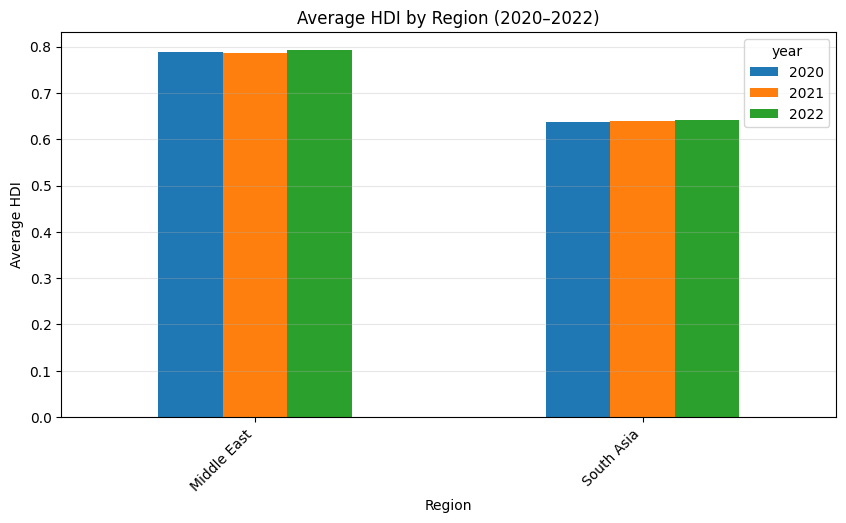

,region,year,hdi
0,Middle East,2020,0.787818
1,Middle East,2021,0.786909
2,Middle East,2022,0.792000
3,South Asia,2020,0.637625
4,South Asia,2021,0.638625


In [19]:
if len(region_col_candidates) == 0:
    print("Region variable not available in the dataset.")
else:
    region_col = region_col_candidates[0]
    avg_region_year = (hdi_1b.groupby([region_col, "year"])["hdi"].mean().reset_index())

    # Pivot for grouped bars
    pivot = avg_region_year.pivot(index=region_col, columns="year", values="hdi").sort_index()
    pivot.plot(kind="bar", figsize=(10, 5))
    plt.title("Average HDI by Region (2020–2022)")
    plt.xlabel("Region")
    plt.ylabel("Average HDI")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

    display(avg_region_year.head())


### 2) Box Plot: HDI Distribution for 2020, 2021, 2022

/tmp/ipython-input-4138394045.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=[str(y) for y in years_1b], showmeans=True)


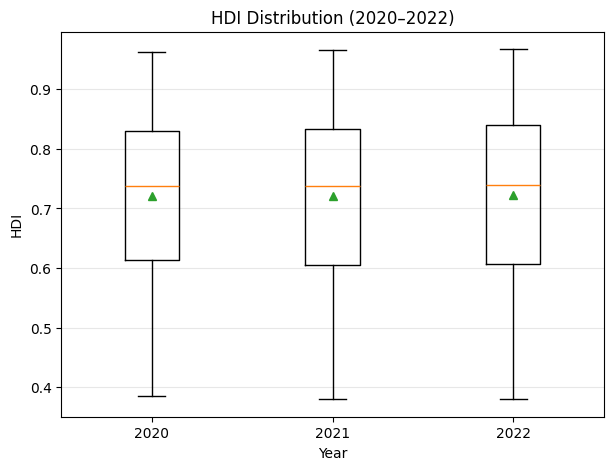

Comment: Compare medians and spread (IQR) across years to see distribution shifts.


In [20]:
data_box = [hdi_1b[hdi_1b["year"] == y]["hdi"].dropna().values for y in years_1b]

plt.figure(figsize=(7, 5))
plt.boxplot(data_box, labels=[str(y) for y in years_1b], showmeans=True)
plt.title("HDI Distribution (2020–2022)")
plt.xlabel("Year")
plt.ylabel("HDI")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

print("Comment: Compare medians and spread (IQR) across years to see distribution shifts.")


### 3) Scatter Plot: HDI vs GNI per Capita

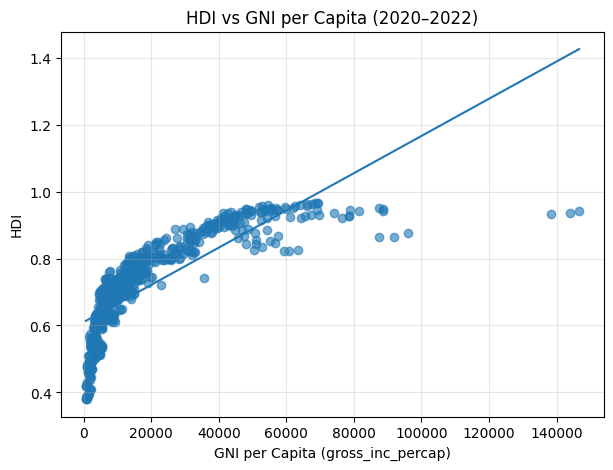

Interpretation: A positive association is typically expected (higher income often aligns with higher HDI).


In [21]:
if "gross_inc_percap" not in hdi_1b.columns:
    print("GNI per Capita variable not available in the dataset.")
else:
    # Use only rows with both values available
    s = hdi_1b.dropna(subset=["gross_inc_percap", "hdi"]).copy()

    plt.figure(figsize=(7, 5))
    plt.scatter(s["gross_inc_percap"], s["hdi"], alpha=0.6)
    plt.title("HDI vs GNI per Capita (2020–2022)")
    plt.xlabel("GNI per Capita (gross_inc_percap)")
    plt.ylabel("HDI")
    plt.grid(True, alpha=0.3)

    # Optional regression line
    x = s["gross_inc_percap"].values
    y = s["hdi"].values
    if len(x) > 2:
        m, b = np.polyfit(x, y, 1)
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = m * x_line + b
        plt.plot(x_line, y_line)
    plt.show()

    print("Interpretation: A positive association is typically expected (higher income often aligns with higher HDI).")


## Task 4 — Short Analysis Questions (computed)

- Which countries show the greatest improvement in HDI from 2020 to 2022?
- Did any countries experience a decline?
- Which region has highest/lowest average HDI (if region exists)?
- Discussion prompt: COVID-19 impact (write-up in markdown cell)


In [22]:
# Compute improvement 2020 -> 2022
pivot_country_year = hdi_1b.pivot_table(index="country", columns="year", values="hdi", aggfunc="mean")
pivot_country_year["change_2020_2022"] = pivot_country_year[2022] - pivot_country_year[2020]
improvement = pivot_country_year["change_2020_2022"].dropna().sort_values(ascending=False)

print("Top 10 improvements (2020→2022):")
display(improvement.head(10).to_frame())

declines = improvement[improvement < 0].sort_values()
print("\nCountries with decline (2020→2022):")
display(declines.head(10).to_frame())

# Region highest/lowest average (if region exists)
if len([c for c in hdi_1b.columns if "region" in c.lower()]) == 0:
    print("\nRegion variable not available in the dataset. (Skip region highest/lowest)")
else:
    region_col = [c for c in hdi_1b.columns if "region" in c.lower()][0]
    region_avg = hdi_1b.groupby(region_col)["hdi"].mean().sort_values(ascending=False)
    print("\nRegion avg HDI (2020–2022) — top and bottom:")
    display(pd.concat([region_avg.head(5), region_avg.tail(5)]).to_frame("avg_hdi"))


Top 10 improvements (2020→2022):


,change_2020_2022
country,
Andorra,0.041
Azerbaijan,0.038
Ecuador,0.031
Maldives,0.025
Mexico,0.024
San Marino,0.023
Tajikistan,0.023
Bahamas,0.022
Kuwait,0.021



Countries with decline (2020→2022):


,change_2020_2022
country,
Timor-Leste,-0.067
Ukraine,-0.028
Afghanistan,-0.026
Namibia,-0.024
Lebanon,-0.019
Saint Vincent and the Grenadines,-0.013
Suriname,-0.012
Eswatini (Kingdom of),-0.012
Gabon,-0.011



Region avg HDI (2020–2022) — top and bottom:


,avg_hdi
region,
Middle East,0.788909
South Asia,0.639583
Middle East,0.788909
South Asia,0.639583


### Discussion: Possible COVID-19 Effects (2020–2022)

A common interpretation is that the COVID-19 pandemic (especially in 2020–2021) could reduce HDI through:
- reduced life expectancy (health shock),
- schooling disruptions (education),
- reduced income/economic activity (standard of living).



# Problem 2 — Advanced HDI Exploration (South Asia focus)

## Task 1 — Create South Asia subset and Save

Countries:
`["Afghanistan", "Bangladesh", "Bhutan", "India", "Maldives", "Nepal", "Pakistan", "Sri Lanka"]`

Export: **`HDI SouthAsia.csv`**


In [23]:
south_asia = ["Afghanistan", "Bangladesh", "Bhutan", "India",
              "Maldives", "Nepal", "Pakistan", "Sri Lanka"]

hdi_sa = df[df["country"].isin(south_asia)].copy()
hdi_sa = hdi_sa.dropna(subset=["country", "year", "hdi"]).drop_duplicates()

out_sa = "/content/drive/MyDrive/HDI SouthAsia.csv"
hdi_sa.to_csv(out_sa, index=False)
print("Saved:", out_sa, "Shape:", hdi_sa.shape)

hdi_sa.head()


Saved: /content/drive/MyDrive/HDI SouthAsia.csv Shape: (239, 30)


,Unnamed: 0,iso3,country,year,hdi,life_expectancy,pop_millions,hdi_f,hdi_m,life_expec_f,...,gender_development,gender_inequality,secondary_education_f_%,secondary_education_m_%,seats_in_parliament_f_%,seats_in_parliament_m_%,labour_participation_f_%,labour_participation_m_%,co2_emission_tons,mat_footprint_percap_tons
0,1,AFG,Afghanistan,1990,0.284,45.967,10.694796,NaN,NaN,48.397,...,NaN,NaN,1.107733,7.899011,NaN,NaN,NaN,NaN,0.189279,2.1809
1,2,AFG,Afghanistan,1991,0.292,46.663,10.745167,NaN,NaN,49.144,...,NaN,NaN,1.221396,8.137953,NaN,NaN,NaN,NaN,0.178155,2.5264
2,3,AFG,Afghanistan,1992,0.299,47.596,12.057433,NaN,NaN,50.320,...,NaN,NaN,1.335059,8.376896,NaN,NaN,NaN,NaN,0.122920,2.6421
3,4,AFG,Afghanistan,1993,0.307,51.466,14.003760,NaN,NaN,52.739,...,NaN,NaN,1.448722,8.615838,NaN,NaN,NaN,NaN,0.106179,2.3022
4,5,AFG,Afghanistan,1994,0.300,51.495,15.455554,NaN,NaN,53.544,...,NaN,NaN,1.562385,8.854780,NaN,NaN,NaN,NaN,0.094063,1.8948


## Task 2 — Composite Development Score

Formula:
`Composite Score = 0.30 × life_expectancy + 0.30 × gross_inc_percap`

We rank South Asian countries by Composite Score (for latest year 2022 for a clear single-year ranking),
plot top 5, and compare with HDI ranking.


In [24]:
sa_2022 = hdi_sa[hdi_sa["year"] == 2022].copy()

# Ensure needed columns exist
needed = ["life_expectancy", "gross_inc_percap", "hdi"]
missing = [c for c in needed if c not in sa_2022.columns]
print("Missing required columns:", missing)

sa_2022 = sa_2022.dropna(subset=needed)

sa_2022["Composite Score"] = 0.30 * sa_2022["life_expectancy"] + 0.30 * sa_2022["gross_inc_percap"]

rank_comp = sa_2022.sort_values("Composite Score", ascending=False)[["country", "Composite Score", "hdi"]]
rank_hdi  = sa_2022.sort_values("hdi", ascending=False)[["country", "hdi", "Composite Score"]]

print("Composite Score ranking (2022):")
display(rank_comp)

print("HDI ranking (2022):")
display(rank_hdi)


Missing required columns: []
Composite Score ranking (2022):


,country,Composite Score,hdi
3530,Maldives,5678.289357,0.762
5477,Sri Lanka,3592.832541,0.780
659,Bhutan,3209.130864,0.681
2573,India,2105.481239,0.644
461,Bangladesh,1975.446053,0.670
4388,Pakistan,1632.210427,0.540
4091,Nepal,1228.811605,0.601
32,Afghanistan,419.425420,0.462


HDI ranking (2022):


,country,hdi,Composite Score
5477,Sri Lanka,0.780,3592.832541
3530,Maldives,0.762,5678.289357
659,Bhutan,0.681,3209.130864
461,Bangladesh,0.670,1975.446053
2573,India,0.644,2105.481239
4091,Nepal,0.601,1228.811605
4388,Pakistan,0.540,1632.210427
32,Afghanistan,0.462,419.425420


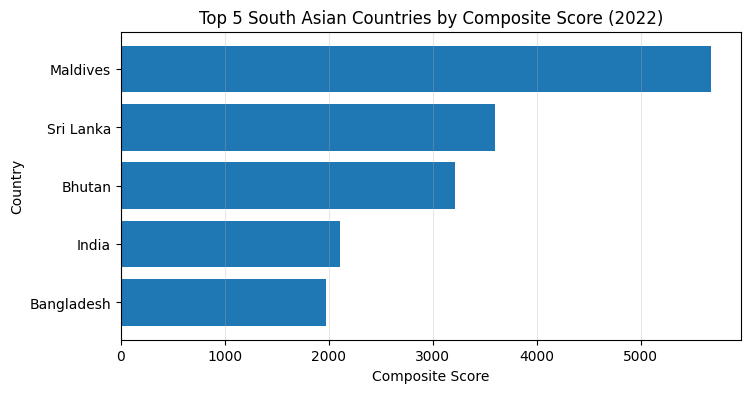

Discussion note: Differences from HDI ranking can occur because HDI uses multiple normalized indices and a geometric mean.


In [25]:
top5 = rank_comp.head(5).sort_values("Composite Score", ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(top5["country"], top5["Composite Score"])
plt.title("Top 5 South Asian Countries by Composite Score (2022)")
plt.xlabel("Composite Score")
plt.ylabel("Country")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

print("Discussion note: Differences from HDI ranking can occur because HDI uses multiple normalized indices and a geometric mean.")


## Task 3 — Outlier Detection (1.5 × IQR) for HDI and GNI per Capita

We detect outliers and highlight them on a scatter plot (GNI per Capita vs HDI).

In [26]:
def iqr_outliers(series: pd.Series):
    s = series.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

sa_plot = sa_2022.dropna(subset=["gross_inc_percap", "hdi"]).copy()

hdi_lo, hdi_hi = iqr_outliers(sa_plot["hdi"])
gni_lo, gni_hi = iqr_outliers(sa_plot["gross_inc_percap"])

sa_plot["outlier"] = (
    (sa_plot["hdi"] < hdi_lo) | (sa_plot["hdi"] > hdi_hi) |
    (sa_plot["gross_inc_percap"] < gni_lo) | (sa_plot["gross_inc_percap"] > gni_hi)
)

print("Outliers detected (South Asia, 2022):")
display(sa_plot[sa_plot["outlier"]][["country", "hdi", "gross_inc_percap"]])


Outliers detected (South Asia, 2022):


,country,hdi,gross_inc_percap


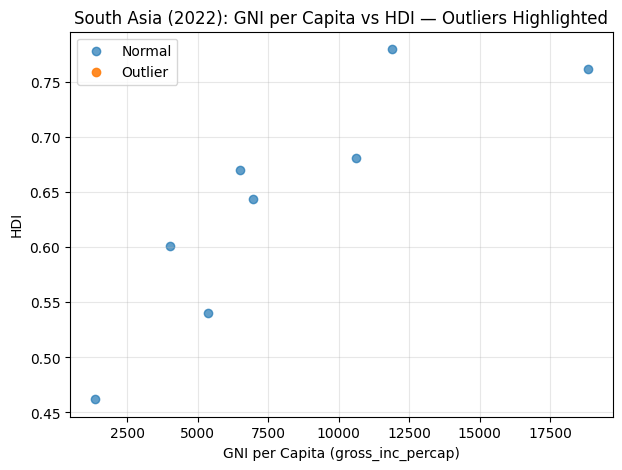

Discussion note: Outliers may reflect countries with unusually high/low income relative to HDI, or unique development patterns.


In [27]:
plt.figure(figsize=(7, 5))
normal = sa_plot[~sa_plot["outlier"]]
outl = sa_plot[sa_plot["outlier"]]

plt.scatter(normal["gross_inc_percap"], normal["hdi"], alpha=0.7, label="Normal")
plt.scatter(outl["gross_inc_percap"], outl["hdi"], alpha=0.9, label="Outlier")

plt.title("South Asia (2022): GNI per Capita vs HDI — Outliers Highlighted")
plt.xlabel("GNI per Capita (gross_inc_percap)")
plt.ylabel("HDI")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Discussion note: Outliers may reflect countries with unusually high/low income relative to HDI, or unique development patterns.")


## Task 4 — Exploring Metric Relationships

We select:
- `gender_development`
- `life_expectancy`

Compute Pearson correlation with HDI and visualize with scatter plots + trendlines.


In [28]:
metrics = ["gender_development", "life_expectancy"]
available = [m for m in metrics if m in sa_2022.columns]
print("Metrics available:", available)

for m in available:
    tmp = sa_2022.dropna(subset=[m, "hdi"])
    corr = tmp[m].corr(tmp["hdi"], method="pearson")
    print(f"Pearson corr({m}, HDI) = {corr:.4f}")


Metrics available: ['gender_development', 'life_expectancy']
Pearson corr(gender_development, HDI) = 0.8848
Pearson corr(life_expectancy, HDI) = 0.9282


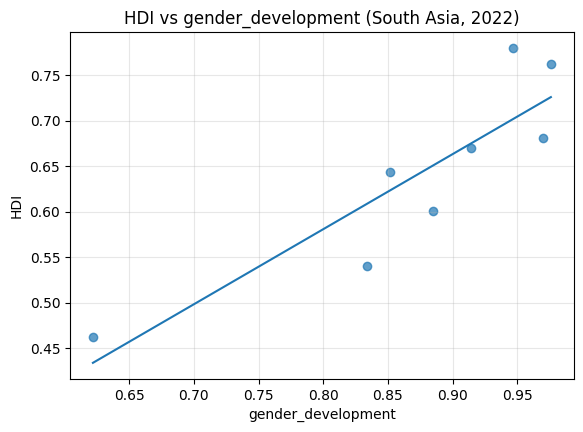

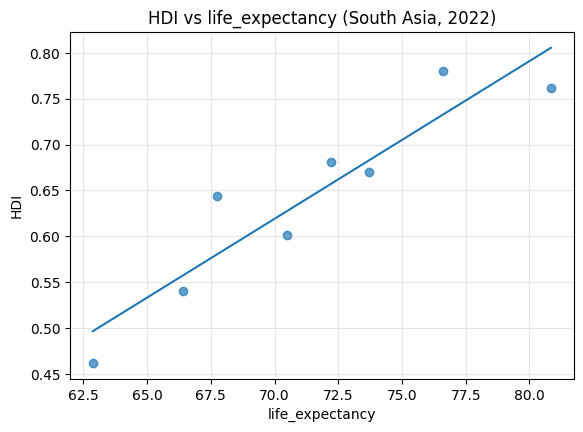

Discussion prompt: Identify which metric shows the strongest vs weakest relationship based on correlation magnitude.


In [29]:
for m in available:
    tmp = sa_2022.dropna(subset=[m, "hdi"]).copy()
    plt.figure(figsize=(6.5, 4.5))
    plt.scatter(tmp[m], tmp["hdi"], alpha=0.7)
    plt.title(f"HDI vs {m} (South Asia, 2022)")
    plt.xlabel(m)
    plt.ylabel("HDI")
    plt.grid(True, alpha=0.3)

    # Trendline
    x = tmp[m].values
    y = tmp["hdi"].values
    if len(x) > 2:
        m_slope, b = np.polyfit(x, y, 1)
        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = m_slope * x_line + b
        plt.plot(x_line, y_line)
    plt.show()

print("Discussion prompt: Identify which metric shows the strongest vs weakest relationship based on correlation magnitude.")


## Task 5 — Gap Analysis

`GNI HDI Gap = gross_inc_percap − hdi`

- Rank descending & ascending
- Plot top 3 positive and top 3 negative gaps


In [30]:
sa_2022["GNI_HDI_Gap"] = sa_2022["gross_inc_percap"] - sa_2022["hdi"]

rank_gap_desc = sa_2022.sort_values("GNI_HDI_Gap", ascending=False)[["country", "GNI_HDI_Gap", "gross_inc_percap", "hdi"]]
rank_gap_asc  = sa_2022.sort_values("GNI_HDI_Gap", ascending=True)[["country", "GNI_HDI_Gap", "gross_inc_percap", "hdi"]]

print("Top gaps (descending):")
display(rank_gap_desc)

print("Bottom gaps (ascending):")
display(rank_gap_asc)


Top gaps (descending):


,country,GNI_HDI_Gap,gross_inc_percap,hdi
3530,Maldives,18846.030190,18846.792190,0.762
5477,Sri Lanka,11898.718470,11899.498470,0.780
659,Bhutan,10624.192880,10624.873880,0.681
2573,India,6949.882798,6950.526798,0.644
461,Bangladesh,6510.452178,6511.122178,0.670
4388,Pakistan,5373.730423,5374.270423,0.540
4091,Nepal,4024.953685,4025.554685,0.601
32,Afghanistan,1334.743733,1335.205733,0.462


Bottom gaps (ascending):


,country,GNI_HDI_Gap,gross_inc_percap,hdi
32,Afghanistan,1334.743733,1335.205733,0.462
4091,Nepal,4024.953685,4025.554685,0.601
4388,Pakistan,5373.730423,5374.270423,0.540
461,Bangladesh,6510.452178,6511.122178,0.670
2573,India,6949.882798,6950.526798,0.644
659,Bhutan,10624.192880,10624.873880,0.681
5477,Sri Lanka,11898.718470,11899.498470,0.780
3530,Maldives,18846.030190,18846.792190,0.762


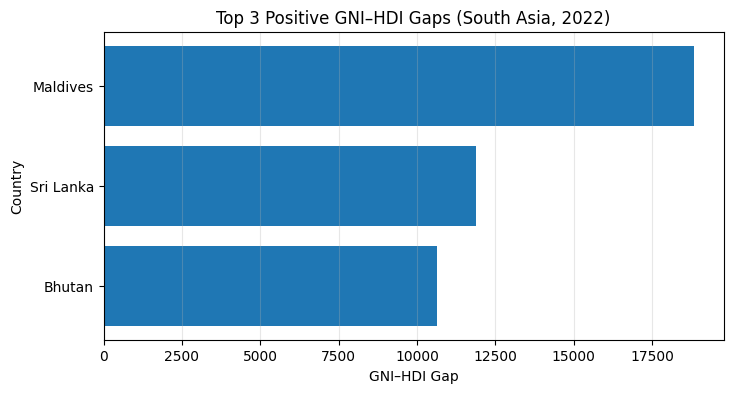

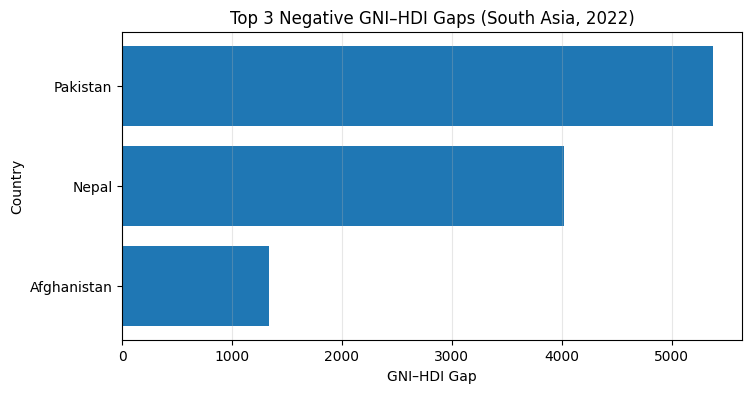

Interpretation prompt: High positive gaps may indicate relatively high income but HDI not as high; negative gaps can indicate strong HDI relative to income.


In [31]:
top_pos = rank_gap_desc.head(3).sort_values("GNI_HDI_Gap", ascending=True)
top_neg = rank_gap_asc.head(3).sort_values("GNI_HDI_Gap", ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(top_pos["country"], top_pos["GNI_HDI_Gap"])
plt.title("Top 3 Positive GNI–HDI Gaps (South Asia, 2022)")
plt.xlabel("GNI–HDI Gap")
plt.ylabel("Country")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

plt.figure(figsize=(8, 4))
plt.barh(top_neg["country"], top_neg["GNI_HDI_Gap"])
plt.title("Top 3 Negative GNI–HDI Gaps (South Asia, 2022)")
plt.xlabel("GNI–HDI Gap")
plt.ylabel("Country")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

print("Interpretation prompt: High positive gaps may indicate relatively high income but HDI not as high; negative gaps can indicate strong HDI relative to income.")


# Problem 3 — Comparative Regional Analysis: South Asia vs Middle East (2020–2022)

## Task 1 — Create Middle East subset (from Problem 1B dataset) and Save

Exports:
- `HDI SouthAsia 2020 2022.csv`
- `HDI MiddleEast 2020 2022.csv`


In [32]:
middle_east = ["Bahrain", "Iran", "Iraq", "Israel", "Jordan",
              "Kuwait", "Lebanon", "Oman", "Palestine", "Qatar", "Saudi Arabia",
              "Syria", "United Arab Emirates", "Yemen"]

sa_1b = hdi_1b[hdi_1b["country"].isin(south_asia)].copy()
me_1b = hdi_1b[hdi_1b["country"].isin(middle_east)].copy()

out_sa_1b = "/content/drive/MyDrive/HDI SouthAsia 2020 2022.csv"
out_me_1b = "/content/drive/MyDrive/HDI MiddleEast 2020 2022.csv"

sa_1b.to_csv(out_sa_1b, index=False)
me_1b.to_csv(out_me_1b, index=False)

print("Saved:", out_sa_1b, "shape:", sa_1b.shape)
print("Saved:", out_me_1b, "shape:", me_1b.shape)

sa_1b.head()


Saved: /content/drive/MyDrive/HDI SouthAsia 2020 2022.csv shape: (24, 31)
Saved: /content/drive/MyDrive/HDI MiddleEast 2020 2022.csv shape: (33, 31)


,Unnamed: 0,iso3,country,year,hdi,life_expectancy,pop_millions,hdi_f,hdi_m,life_expec_f,...,gender_inequality,secondary_education_f_%,secondary_education_m_%,seats_in_parliament_f_%,seats_in_parliament_m_%,labour_participation_f_%,labour_participation_m_%,co2_emission_tons,mat_footprint_percap_tons,region
30,31,AFG,Afghanistan,2020,0.488,62.575,38.972231,0.381373,0.548741,65.432,...,0.674,6.092345,15.945160,27.215190,72.784810,16.50,66.84,0.305040,1.5554,South Asia
31,32,AFG,Afghanistan,2021,0.473,61.982,40.099462,0.379129,0.528559,65.279,...,0.653,6.395730,14.865710,27.215190,72.784810,23.33,77.09,0.306318,1.2351,South Asia
32,33,AFG,Afghanistan,2022,0.462,62.879,41.128771,0.332443,0.534145,66.213,...,0.665,7.042050,24.077040,27.215190,72.784810,23.33,77.09,0.306318,1.1809,South Asia
459,460,BGD,Bangladesh,2020,0.657,71.968,167.420951,0.619431,0.682912,73.957,...,0.502,43.659868,50.507937,20.916905,79.083095,38.74,81.27,0.559159,4.5993,South Asia
460,461,BGD,Bangladesh,2021,0.662,72.381,169.356251,0.624949,0.687950,74.267,...,0.500,43.659868,50.507937,20.857143,79.142857,39.15,81.39,0.583153,4.6834,South Asia


## Task 2 — Descriptive Statistics (mean & std of HDI)

Compute mean and std across 2020–2022 for each region subset.

In [33]:
def region_stats(df_region: pd.DataFrame, region_name: str):
    mean_hdi = df_region["hdi"].mean()
    std_hdi = df_region["hdi"].std()
    return pd.Series({"region": region_name, "mean_hdi": mean_hdi, "std_hdi": std_hdi})

stats = pd.DataFrame([
    region_stats(sa_1b, "South Asia"),
    region_stats(me_1b, "Middle East")
])

stats


,region,mean_hdi,std_hdi
0,South Asia,0.639583,0.098273
1,Middle East,0.788909,0.141295


## Task 3 — Top and Bottom Performers (HDI)

Top 3 and bottom 3 countries (average HDI across 2020–2022), and a bar chart comparing them.

In [34]:
def top_bottom(df_region: pd.DataFrame, n=3):
    avg = df_region.groupby("country")["hdi"].mean().sort_values(ascending=False)
    top = avg.head(n)
    bottom = avg.tail(n)
    return top, bottom

sa_top, sa_bottom = top_bottom(sa_1b, 3)
me_top, me_bottom = top_bottom(me_1b, 3)

print("South Asia top 3:")
display(sa_top.to_frame("avg_hdi"))

print("South Asia bottom 3:")
display(sa_bottom.to_frame("avg_hdi"))

print("Middle East top 3:")
display(me_top.to_frame("avg_hdi"))

print("Middle East bottom 3:")
display(me_bottom.to_frame("avg_hdi"))


South Asia top 3:


,avg_hdi
country,
Sri Lanka,0.780000
Maldives,0.750667
Bhutan,0.677667


South Asia bottom 3:


,avg_hdi
country,
Nepal,0.595000
Pakistan,0.537667
Afghanistan,0.474333


Middle East top 3:


,avg_hdi
country,
United Arab Emirates,0.932667
Israel,0.910667
Bahrain,0.885333


Middle East bottom 3:


,avg_hdi
country,
Lebanon,0.730000
Iraq,0.667000
Yemen,0.426333


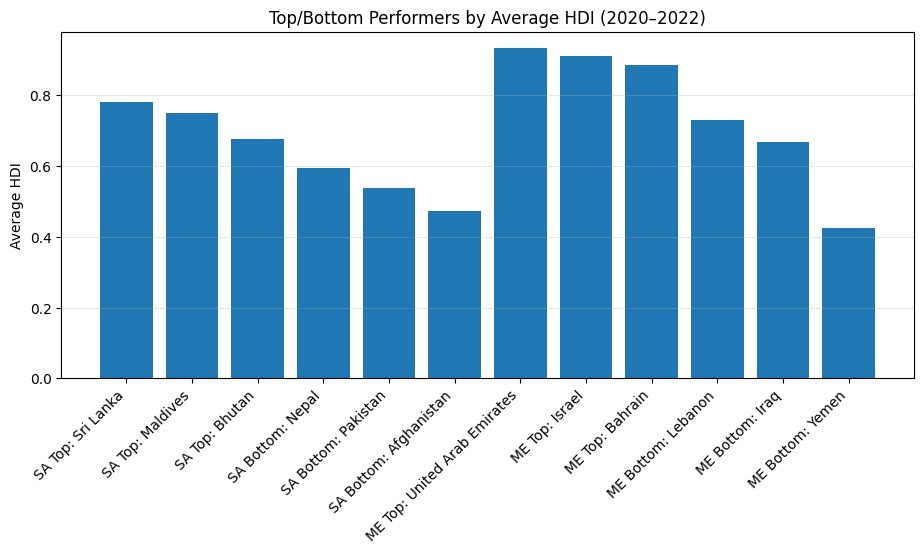

In [35]:
labels = (["SA Top: " + c for c in sa_top.index] +
          ["SA Bottom: " + c for c in sa_bottom.index] +
          ["ME Top: " + c for c in me_top.index] +
          ["ME Bottom: " + c for c in me_bottom.index])

values = list(sa_top.values) + list(sa_bottom.values) + list(me_top.values) + list(me_bottom.values)

plt.figure(figsize=(11, 4.5))
plt.bar(labels, values)
plt.title("Top/Bottom Performers by Average HDI (2020–2022)")
plt.ylabel("Average HDI")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


## Task 4 — Metric Comparisons (grouped bar charts)

Compare across regions:
- `gender_development`
- `life_expectancy`
- `gross_inc_percap`

We compare region-wide averages (2020–2022).

In [36]:
compare_metrics = ["gender_development", "life_expectancy", "gross_inc_percap"]
compare_metrics = [m for m in compare_metrics if m in hdi_1b.columns]
print("Metrics available for comparison:", compare_metrics)

def metric_means(df_region: pd.DataFrame, region_name: str):
    d = {"region": region_name}
    for m in compare_metrics:
        d[m] = df_region[m].mean()
    return d

metric_table = pd.DataFrame([
    metric_means(sa_1b, "South Asia"),
    metric_means(me_1b, "Middle East")
])

metric_table


Metrics available for comparison: ['gender_development', 'life_expectancy', 'gross_inc_percap']


,region,gender_development,life_expectancy,gross_inc_percap
0,South Asia,0.881458,70.970083,7766.509931
1,Middle East,0.896545,75.855455,37750.770520


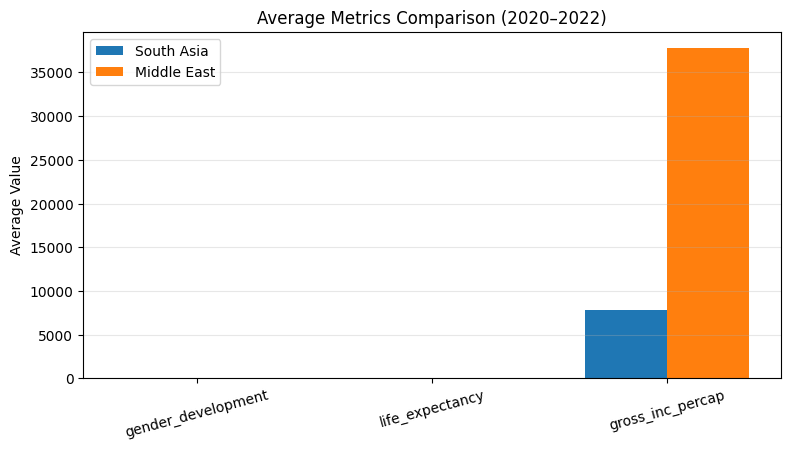

Greatest disparity metric: gross_inc_percap Abs diff: 29984.260588178036


In [37]:
if len(compare_metrics) == 0:
    print("Required metrics not available in dataset.")
else:
    x = np.arange(len(compare_metrics))
    width = 0.35

    sa_vals = metric_table[metric_table["region"]=="South Asia"][compare_metrics].values.flatten()
    me_vals = metric_table[metric_table["region"]=="Middle East"][compare_metrics].values.flatten()

    plt.figure(figsize=(9, 4.5))
    plt.bar(x - width/2, sa_vals, width, label="South Asia")
    plt.bar(x + width/2, me_vals, width, label="Middle East")

    plt.xticks(x, compare_metrics, rotation=15)
    plt.title("Average Metrics Comparison (2020–2022)")
    plt.ylabel("Average Value")
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.show()

    diffs = np.abs(me_vals - sa_vals)
    if len(diffs) > 0:
        max_idx = int(np.argmax(diffs))
        print("Greatest disparity metric:", compare_metrics[max_idx], "Abs diff:", diffs[max_idx])


## Task 5 — HDI Disparity within each region

- Range: max − min
- Coefficient of Variation: CV = std/mean


In [38]:
def disparity(df_region: pd.DataFrame, region_name: str):
    h = df_region["hdi"].dropna()
    r = h.max() - h.min()
    mean = h.mean()
    std = h.std()
    cv = std / mean if mean != 0 else np.nan
    return pd.Series({"region": region_name, "range_hdi": r, "cv_hdi": cv})

disp = pd.DataFrame([
    disparity(sa_1b, "South Asia"),
    disparity(me_1b, "Middle East")
])
disp


,region,range_hdi,cv_hdi
0,South Asia,0.321,0.153652
1,Middle East,0.513,0.179101


## Task 6 — Correlation Analysis (per region)

Compute correlation of HDI with:
- gender_development
- life_expectancy

Create scatter plots with trendlines.


In [39]:
corr_metrics = [m for m in ["gender_development", "life_expectancy"] if m in hdi_1b.columns]
print("Correlation metrics available:", corr_metrics)

def corr_table(df_region: pd.DataFrame, region_name: str):
    rows = []
    for m in corr_metrics:
        tmp = df_region.dropna(subset=["hdi", m])
        corr = tmp["hdi"].corr(tmp[m], method="pearson")
        rows.append({"region": region_name, "metric": m, "pearson_corr": corr})
    return pd.DataFrame(rows)

corr_df = pd.concat([corr_table(sa_1b, "South Asia"), corr_table(me_1b, "Middle East")], ignore_index=True)
corr_df


Correlation metrics available: ['gender_development', 'life_expectancy']


,region,metric,pearson_corr
0,South Asia,gender_development,0.874218
1,South Asia,life_expectancy,0.938764
2,Middle East,gender_development,0.935670
3,Middle East,life_expectancy,0.933123


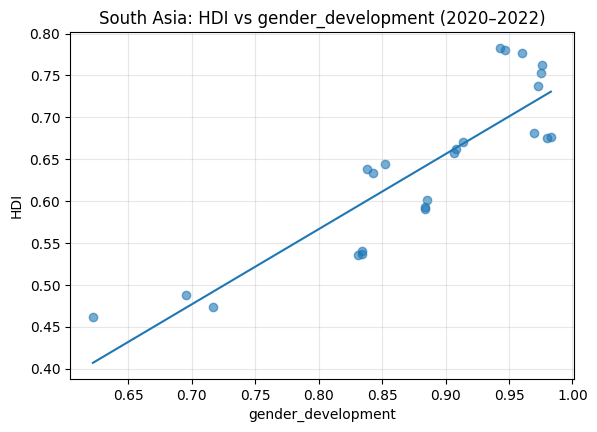

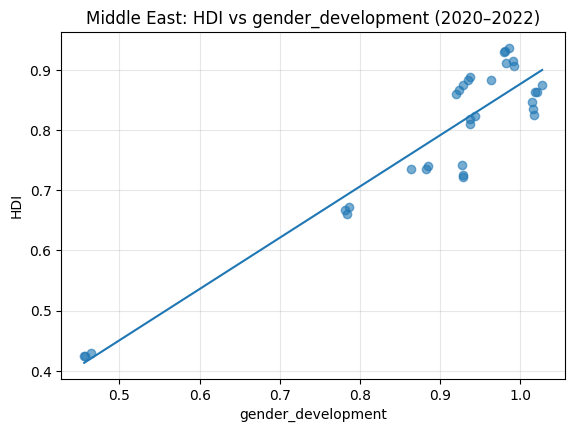

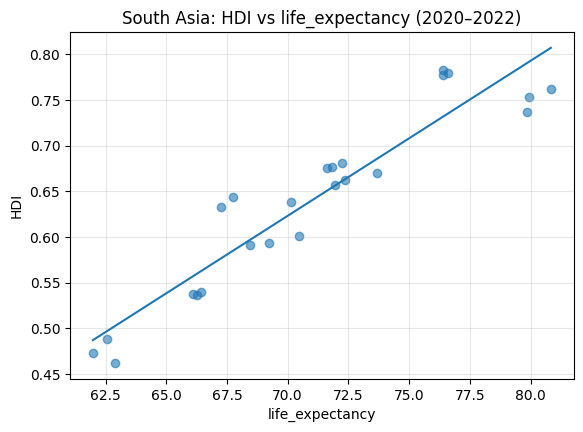

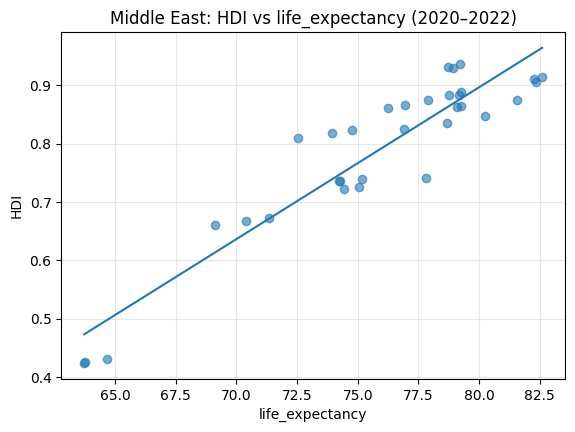

In [40]:
def scatter_with_trend(df_region: pd.DataFrame, region_name: str, metric: str):
    tmp = df_region.dropna(subset=["hdi", metric])
    plt.figure(figsize=(6.5, 4.5))
    plt.scatter(tmp[metric], tmp["hdi"], alpha=0.6)
    plt.title(f"{region_name}: HDI vs {metric} (2020–2022)")
    plt.xlabel(metric)
    plt.ylabel("HDI")
    plt.grid(True, alpha=0.3)

    x = tmp[metric].values
    y = tmp["hdi"].values
    if len(x) > 2:
        m_slope, b = np.polyfit(x, y, 1)
        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = m_slope * x_line + b
        plt.plot(x_line, y_line)
    plt.show()

for metric in corr_metrics:
    scatter_with_trend(sa_1b, "South Asia", metric)
    scatter_with_trend(me_1b, "Middle East", metric)


## Task 7 — Outlier Detection (1.5 × IQR) within each region

Detect outliers in:
- `hdi`
- `gross_inc_percap`

Create scatter plots highlighting outliers.


In [41]:
def mark_outliers(df_region: pd.DataFrame) -> pd.DataFrame:
    d = df_region.dropna(subset=["hdi", "gross_inc_percap"]).copy()
    h_lo, h_hi = iqr_outliers(d["hdi"])
    g_lo, g_hi = iqr_outliers(d["gross_inc_percap"])
    d["outlier"] = (
        (d["hdi"] < h_lo) | (d["hdi"] > h_hi) |
        (d["gross_inc_percap"] < g_lo) | (d["gross_inc_percap"] > g_hi)
    )
    return d

sa_out = mark_outliers(sa_1b)
me_out = mark_outliers(me_1b)

print("South Asia outliers (rows):", sa_out["outlier"].sum())
display(sa_out[sa_out["outlier"]][["country", "year", "hdi", "gross_inc_percap"]].head(20))

print("Middle East outliers (rows):", me_out["outlier"].sum())
display(me_out[me_out["outlier"]][["country", "year", "hdi", "gross_inc_percap"]].head(20))


South Asia outliers (rows): 0


,country,year,hdi,gross_inc_percap


Middle East outliers (rows): 3


,country,year,hdi,gross_inc_percap
6366,Yemen,2020,0.430,1152.015672
6367,Yemen,2021,0.425,1112.162989
6368,Yemen,2022,0.424,1105.763435


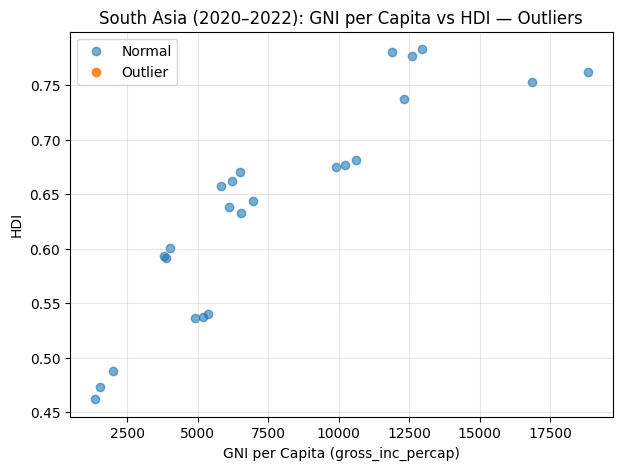

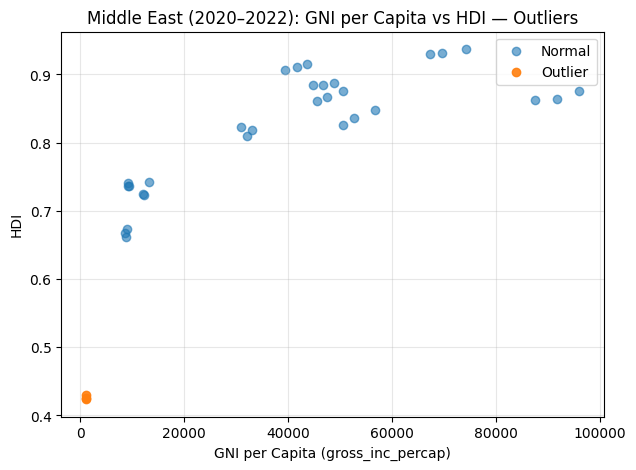

Discussion prompt: Explain why these outliers stand out (e.g., very high income states, conflict-affected states, etc.).


In [42]:
def outlier_scatter(d: pd.DataFrame, title: str):
    normal = d[~d["outlier"]]
    outl = d[d["outlier"]]

    plt.figure(figsize=(7, 5))
    plt.scatter(normal["gross_inc_percap"], normal["hdi"], alpha=0.6, label="Normal")
    plt.scatter(outl["gross_inc_percap"], outl["hdi"], alpha=0.9, label="Outlier")
    plt.title(title)
    plt.xlabel("GNI per Capita (gross_inc_percap)")
    plt.ylabel("HDI")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

outlier_scatter(sa_out, "South Asia (2020–2022): GNI per Capita vs HDI — Outliers")
outlier_scatter(me_out, "Middle East (2020–2022): GNI per Capita vs HDI — Outliers")

print("Discussion prompt: Explain why these outliers stand out (e.g., very high income states, conflict-affected states, etc.).")



 CSV files

- `HDI category added.csv`
- `HDI problem1B.csv`
- `HDI SouthAsia.csv`
- `HDI SouthAsia 2020 2022.csv`
- `HDI MiddleEast 2020 2022.csv`

